# Data Science Challenge

The data is available as two CSV files:
- takehome_user_engagement.csv
- takehome_users.csv

The data has the following two tables:

A] A user table "takehome_users" with data on 12,000 users who signed up for the product in the last two years. This table includes:

    ● name: the user's name
    ● object_id: the user's id
    ● email: email address
    ● creation_source: how their account was created. This takes on one of 5 values:
        ○ PERSONAL_PROJECTS: invited to join another user's personal workspace
        ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)
        ○ ORG_INVITE: invited to an organization (as a full member)
        ○ SIGNUP: signed up via the website
        ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
    ● creation_time: when they created their account
    ● last_session_creation_time: unix timestamp of last login
    ● opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    ● enabled_for_marketing_drip: whether they are on the regular marketing email drip
    ● org_id: the organization (group of users) they belong to
    ● invited_by_user_id: which user invited them to join (if applicable).

B] A usage summary table "takehome_user_engagement" has a row for each day that a user logged into the product.

Q. Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [0]:
# import data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# get version of imported libraries
print(f'Pandas version : {pd.__version__}')
print(f'Numpy version : {np.__version__}')
print(f'sklearn version : {sklearn.__version__}')

Pandas version : 0.25.3
Numpy version : 1.17.5
sklearn version : 0.22.1


In [3]:
# mount google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read 'user' data as a pandas dataframe
u = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Takehome Assignments/relax/data/takehome_users.csv', encoding='latin-1')

In [5]:
# check out 'user' data
u.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
# get summary of 'user' data
u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [0]:
# read 'user_engagement' data as a pandas dataframe
ue = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Takehome Assignments/relax/data/takehome_user_engagement.csv')

In [8]:
# check out 'user_engagement' data
ue.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [0]:
# set index as datetime
ue = ue.set_index(pd.DatetimeIndex(ue['time_stamp']))

In [10]:
ue.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [11]:
# get summary of 'user_engagement' data
ue.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.3+ MB


In [12]:
# check for null values in 'user_engagement'
ue.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

## Date Wrangling

### pandas.DataFrame.resample( )

    (self, rule, axis=0, closed: Union[str, NoneType] = None, label: Union[str, NoneType] = None, convention: str = 'start', kind: Union[str, NoneType] = None, loffset=None, base: int = 0, on=None, level=None)

Convenience method for frequency conversion and resampling of time series. Object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or pass datetime-like values to the on or level keyword.

In [0]:
# group 'user_engagement' data by 'user_id', resample it by 1 Week and sum the number of visits per week
grouped_ue = ue.groupby('user_id').resample('1W').sum()

In [14]:
# check grouped user enagement data
grouped_ue.head()

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0

In [15]:
# get summary of grouped user enagement
grouped_ue.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 82282 entries, (1, 2014-04-27 00:00:00) to (12000, 2014-01-26 00:00:00)
Data columns (total 2 columns):
user_id    82282 non-null int64
visited    82282 non-null int64
dtypes: int64(2)
memory usage: 1.6 MB


In [16]:
# check for null values
grouped_ue.user_id.isnull().sum()

0

In [0]:
# drop 'user_id' column
grouped_ue = grouped_ue.drop('user_id',axis=1)

In [18]:
grouped_ue.head(10)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1

In [19]:
# get count of visits for all users
from collections import Counter
Counter(grouped_ue.visited)

Counter({0: 13475,
         1: 23131,
         2: 11817,
         3: 9415,
         4: 7348,
         5: 5756,
         6: 4645,
         7: 6695})

In [20]:
# get total number of users who have visited at least 3 or more times
(grouped_ue.visited>=3).sum()

33859

In [0]:
# select only users as 'active_users' who have visited at least 3 or more times
active_users = grouped_ue['visited']>=3

In [22]:
active_users.head()

user_id  time_stamp
1        2014-04-27    False
2        2013-11-17    False
         2013-11-24    False
         2013-12-01    False
         2013-12-08    False
Name: visited, dtype: bool

### pandas.DataFrame.groupby( )

    (self, by=None, axis=0, level=None, as_index: bool = True, sort: bool = True, group_keys: bool = True, squeeze: bool = False, observed: bool = False) → 'groupby_generic.DataFrameGroupBy'

A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups.

    level = int, level name, or sequence of such, default None
    If the axis is a MultiIndex (hierarchical), group by a particular level or levels.

In [0]:
# group by users and sums up the number of weeks that had 3 or more visits
active_users = active_users.groupby(level=0).apply(np.sum)

In [24]:
active_users.head()

user_id
1    0
2    1
3    0
4    0
5    0
Name: visited, dtype: int64

In [0]:
# remove users with no weeks that had 3 or more visits
active_users = active_users[active_users!=0]

In [26]:
active_users.head()

user_id
2      1
10    52
20     1
33     1
42    68
Name: visited, dtype: int64

In [0]:
# convert data into a dataframe
active_users = pd.DataFrame(active_users, index=active_users.index)

In [28]:
active_users.head()

,visited
user_id,
2,1
10,52
20,1
33,1
42,68


In [0]:
# rename 'visited' column as 'Active Weeks'
active_users.columns = ['Active Weeks']

In [30]:
active_users.head()

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


#### pandas.DataFrame.merge( )
    (self, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None) → 'DataFrame)

The join is done on columns or indexes. If joining columns on columns, the DataFrame indexes will be ignored. Otherwise if joining indexes on indexes or indexes on a column or columns, the index will be passed on.

In [0]:
# merge 'active_users_data' dataframe and user('u') dataframe
active_users_data = active_users.merge(u, left_index=True, right_on='object_id', how='inner')

In [32]:
active_users_data.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [33]:
active_users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 1 to 11987
Data columns (total 11 columns):
Active Weeks                  1445 non-null int64
object_id                     1445 non-null int64
creation_time                 1445 non-null object
name                          1445 non-null object
email                         1445 non-null object
creation_source               1445 non-null object
last_session_creation_time    1445 non-null float64
opted_in_to_mailing_list      1445 non-null int64
enabled_for_marketing_drip    1445 non-null int64
org_id                        1445 non-null int64
invited_by_user_id            817 non-null float64
dtypes: float64(2), int64(5), object(4)
memory usage: 135.5+ KB


In [0]:
# add 'Active' column to 'active_users_data' dataframe
active_users_data['Active'] = 1

In [35]:
active_users_data.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN,1
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0,1
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN,1


In [0]:
# add 'Active' column to 'user' dataframe
u['Active'] = int(0)

In [37]:
u.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [38]:
active_users_data.index

Int64Index([    1,     9,    19,    32,    41,    42,    52,    62,    68,
               73,
            ...
            11956, 11957, 11958, 11960, 11963, 11964, 11966, 11968, 11974,
            11987],
           dtype='int64', length=1445)

In [39]:
u.iloc[list(active_users_data.index),10]

1        0
9        0
19       0
32       0
41       0
        ..
11964    0
11966    0
11968    0
11974    0
11987    0
Name: Active, Length: 1445, dtype: int64

In [0]:
# make 'Active' users from 'active_user_data' dataframe 'Active' in 'user' dataframe
u.iloc[list(active_users_data.index),10] = 1

In [41]:
u.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [0]:
# set index at column 'object_id' and sort the index
model_data = u.set_index('object_id').sort_index()

In [43]:
model_data.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [44]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
Active                        12000 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 1.0+ MB


In [0]:
# drop feature columns which we think are not necessary
model_data = model_data.drop(['creation_time', 'name', 'email'], axis=1)

In [46]:
model_data.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,,
1,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


## Convert Categorical Values

In [47]:
# check unique creation source
print(f'Number of unique creation source {u.creation_source.unique()}')

Number of unique creation source ['GUEST_INVITE' 'ORG_INVITE' 'SIGNUP' 'PERSONAL_PROJECTS'
 'SIGNUP_GOOGLE_AUTH']


### pandas.get_dummies( )

    (data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None) → 'DataFrame'

Convert categorical variable into dummy/indicator variables.

In [0]:
# convert categorical variable into dummy/indicator variables.
dummies = pd.get_dummies(model_data.creation_source, drop_first=True)
model_data = pd.concat([model_data.drop('creation_source', axis=1), dummies], axis=1)

In [49]:
model_data.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1.398139e+09,1,0,11,10803.0,0,0,0,0,0
2,1.396238e+09,0,0,1,316.0,1,1,0,0,0
3,1.363735e+09,0,0,94,1525.0,0,1,0,0,0
4,1.369210e+09,0,0,1,5151.0,0,0,0,0,0
5,1.358850e+09,0,0,193,5240.0,0,0,0,0,0


In [50]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
Active                        12000 non-null int64
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
dtypes: float64(2), int64(4), uint8(4)
memory usage: 703.1 KB


## Impute Missing Values

### Nearest Neighbors Imputation

The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, nan_euclidean_distances, is used to find the nearest neighbors. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. When the number of available neighbors is less than n_neighbors and there are no defined distances to the training set, the training set average for that feature is used during imputation. If there is at least one neighbor with a defined distance, the weighted or unweighted average of the remaining neighbors will be used during imputation. If a feature is always missing in training, it is removed during transform.


In [0]:
from sklearn.impute import KNNImputer

In [0]:
imputed_model_data = KNNImputer(n_neighbors=500)

### numpy.ravel( )
    numpy.ravel(a, order='C')

Return a contiguous flattened array. A 1-D array, containing the elements of the input, is returned. A copy is made only if needed.

    Example :-  x = np.array([[1, 2, 3], [4, 5, 6]])
                np.ravel(x)
                array([1, 2, 3, 4, 5, 6])

In [0]:
# impute missing values for 'invited_by_user_id' feature
model_data['invited_by_user_id'] = imputed_model_data.fit_transform(model_data[['invited_by_user_id']]).ravel()

In [0]:
# impute missing values for 'last_session_creation_time' feature
model_data['last_session_creation_time'] = imputed_model_data.fit_transform(model_data[['last_session_creation_time']]).ravel()

In [55]:
model_data.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1.398139e+09,1,0,11,10803.0,0,0,0,0,0
2,1.396238e+09,0,0,1,316.0,1,1,0,0,0
3,1.363735e+09,0,0,94,1525.0,0,1,0,0,0
4,1.369210e+09,0,0,1,5151.0,0,0,0,0,0
5,1.358850e+09,0,0,193,5240.0,0,0,0,0,0


In [56]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
Active                        12000 non-null int64
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
dtypes: float64(2), int64(4), uint8(4)
memory usage: 703.1 KB


In [57]:
model_data.isnull().sum()

last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
Active                        0
ORG_INVITE                    0
PERSONAL_PROJECTS             0
SIGNUP                        0
SIGNUP_GOOGLE_AUTH            0
dtype: int64

## Exploratory Data Analysis (EDA)

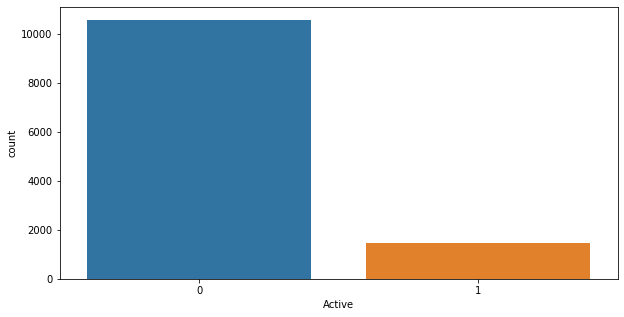

In [58]:
# check number of 'Active' user
plt.figure(figsize=(10,5))
sns.countplot(model_data.Active)

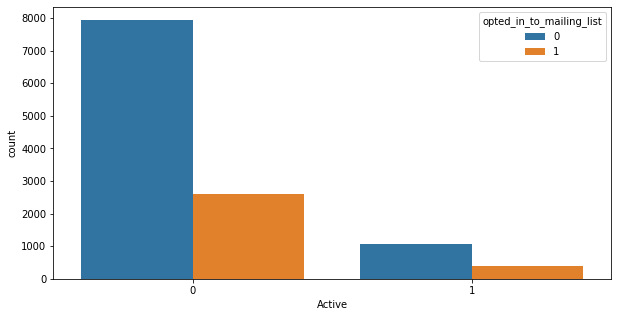

In [59]:
# check how many users have 'opted_in_to_mailing_list' depending upon 'Active' feature
plt.figure(figsize=(10,5))
sns.countplot(model_data.Active, hue=model_data.opted_in_to_mailing_list)

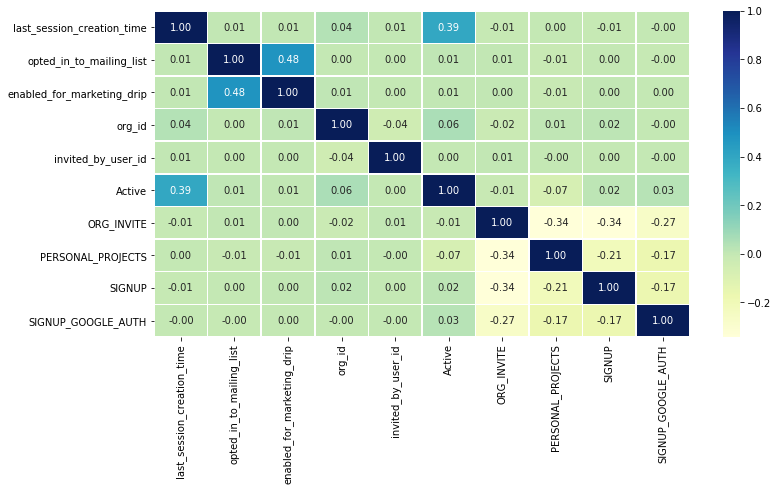

In [60]:
# check correlation between features
plt.figure(figsize=(12,6))
sns.heatmap(data=model_data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap="YlGnBu")

### It seems 'last_session_creation_time' feature is highly correlated to a user been 'Active'

## Build and Evaluate Classification Model

In [0]:
# get X and y data for training and testing the model
X = model_data.drop('Active', axis=1)
y = model_data.Active

In [0]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [0]:
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
# load classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

In [65]:
# instantiate different classifiers
classifiers = [DecisionTreeClassifier(), MLPClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), 
               XGBClassifier(), LGBMClassifier()]

# K-Folds cross-validator
kfold = KFold(n_splits=10)

# check accuracy for different classifiers using K-Folds cross-validation
for clf in classifiers:
    name = clf.__class__.__name__
    accuracy = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')
    print('='*50)
    print(name)
    print(f'Accuracy is {(accuracy.mean()*100):.2f}%')

DecisionTreeClassifier
Accuracy is 89.63%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier
Accuracy is 87.96%
RandomForestClassifier
Accuracy is 92.42%
GradientBoostingClassifier
Accuracy is 92.64%
XGBClassifier
Accuracy is 92.59%
LGBMClassifier
Accuracy is 92.54%


## Machine Learning Interpretability

Check which features are most important in predicting model accuracy

In [66]:
gbc = GradientBoostingClassifier()
gbc.fit(X, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
feature_coef = pd.DataFrame(gbc.feature_importances_).transpose()

In [0]:
feature_coef.columns = list(X.columns)

In [0]:
feature_coef.index = ['GBC']

In [70]:
feature_coef.transpose().sort_values(by='GBC', ascending=False)

,GBC
last_session_creation_time,0.971355
invited_by_user_id,0.015870
org_id,0.010159
enabled_for_marketing_drip,0.001464
SIGNUP,0.000591
PERSONAL_PROJECTS,0.000246
ORG_INVITE,0.000218
SIGNUP_GOOGLE_AUTH,0.000096
opted_in_to_mailing_list,0.000000


### Above table provides the importance of each feature, starting from the top as the most important.

## ML Interpretability using [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations)

SHAP Values breaks down a prediction to show the impact of each feature. Where could you use this?

- A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
- A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [71]:
# install shap
!pip install shap

     |████████████████████████████████| 266kB 4.7MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383196 sha256=f33ffb67a31d4dc1eb801723cf5c978fa6a7f8369a9f67efdd3fa5adffdc9089
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [77]:
# import shap library
import shap
shap.initjs()

In [73]:
# train XGBoost model
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [74]:
# explain the model's predictions using SHAP
shap_explainer = shap.TreeExplainer(xgbc)
shap_values = shap_explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Force Plot

The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

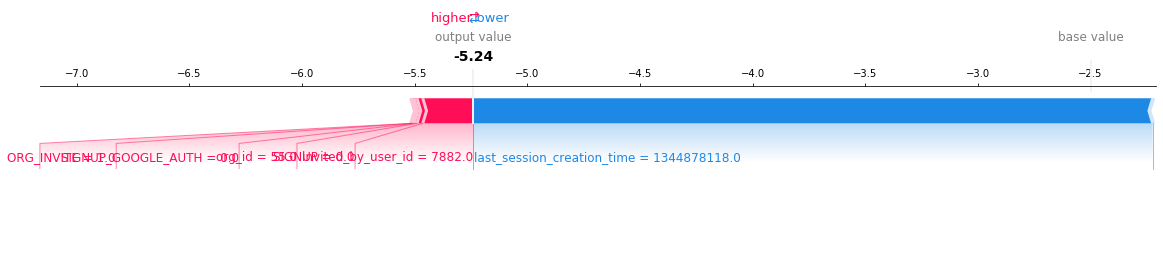

In [75]:
# visualize the 10th prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_explainer.expected_value, shap_values[9,:], X_test.iloc[9,:], matplotlib=True)

In [78]:
# visualize the training set predictions
shap.force_plot(shap_explainer.expected_value, shap_values, X_train)

shap.force_plot is slow for many thousands of rows, try subsampling your data.


### Dependence Plot

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion at a single value represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

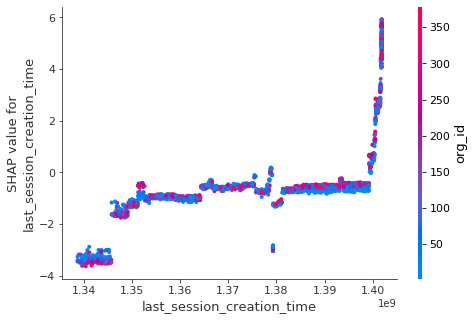

In [79]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('last_session_creation_time', shap_values, X_test)

### Summary Plot

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals that 'last_session_creation_time' predicts future user adoption.

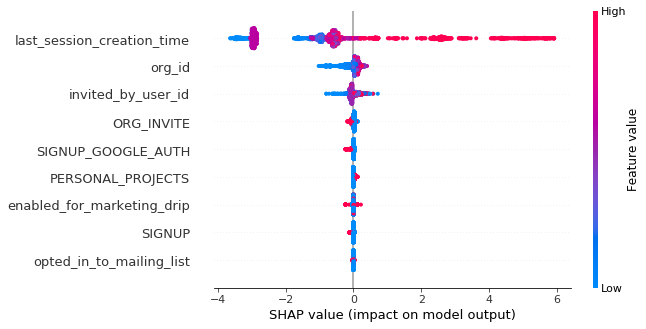

In [80]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs)

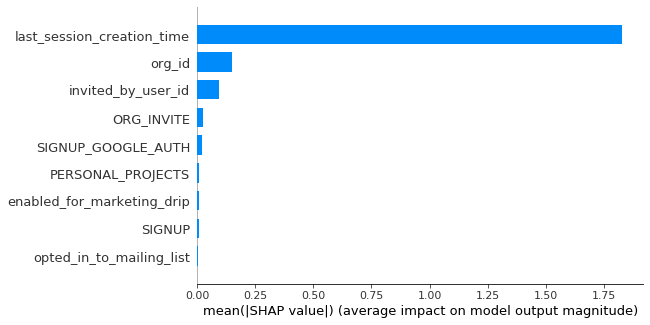

In [81]:
# summarize the effects of all the features using 'plot_type' as 'bar'
shap.summary_plot(shap_values, X_test, plot_type="bar")